__[networkx exploration](https://github.com/apowers313/roc/blob/master/experiments/2024.06.30-08.30.41-networkx-exploration.ipynb)__

In [1]:
!date

Sat Aug 17 07:54:32 PDT 2024


In [2]:
import networkx as nx

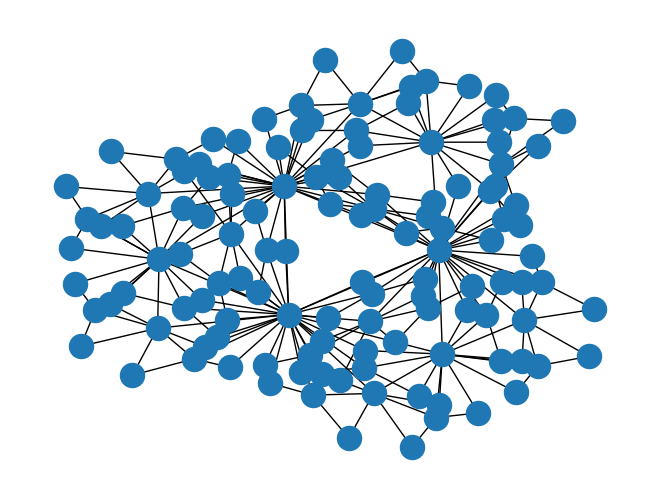

In [3]:
G = nx.dorogovtsev_goltsev_mendes_graph(5)
nx.draw(G)

More graph generators at https://networkx.org/documentation/stable/reference/generators.html

In [4]:
route = nx.shortest_path(G, source=0, target=106)
print(route)

[0, 6, 106]


More graph algorithms at
https://networkx.org/documentation/stable/reference/algorithms/index.html

# Visualizing Routes

The route of the traveller is: [0, 4, 19, 12, 2, 7, 10, 18, 5, 13, 6, 11, 3, 16, 17, 15, 14, 8, 9, 1, 0]
Edge list [(0, 4), (4, 19), (19, 12), (12, 2), (2, 7), (7, 10), (10, 18), (18, 5), (5, 13), (13, 6), (6, 11), (11, 3), (3, 16), (16, 17), (17, 15), (15, 14), (14, 8), (8, 9), (9, 1), (1, 0)]


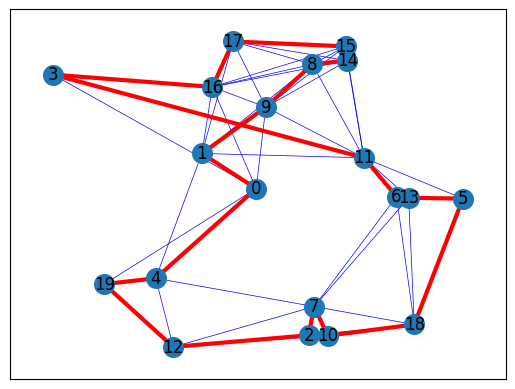

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.approximation as nx_app
import math

G = nx.random_geometric_graph(20, radius=0.4, seed=3)
pos = nx.get_node_attributes(G, "pos")

# Depot should be at (0,0)
pos[0] = (0.5, 0.5)

H = G.copy()


# Calculating the distances between the nodes as edge's weight.
for i in range(len(pos)):
    for j in range(i + 1, len(pos)):
        dist = math.hypot(pos[i][0] - pos[j][0], pos[i][1] - pos[j][1])
        dist = dist
        G.add_edge(i, j, weight=dist)

cycle = nx_app.christofides(G, weight="weight")
edge_list = list(nx.utils.pairwise(cycle))

# Draw closest edges on each node only
nx.draw_networkx_edges(H, pos, edge_color="blue", width=0.5)

# Draw the route
nx.draw_networkx(
    G,
    pos,
    with_labels=True,
    edgelist=edge_list,
    edge_color="red",
    node_size=200,
    width=3,
)

print("The route of the traveller is:", cycle)
print("Edge list", edge_list)
plt.show()

route [0, 2, 14, 122]
edge list [(0, 2), (2, 14), (14, 122)]


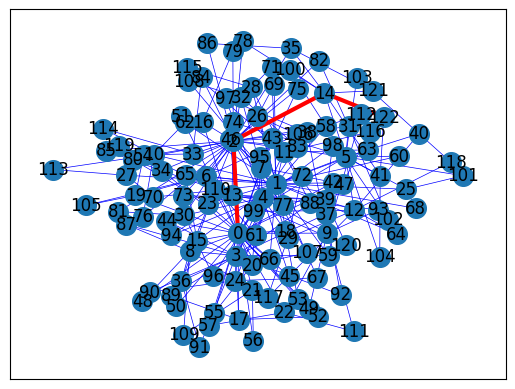

In [6]:
G = nx.dorogovtsev_goltsev_mendes_graph(5)
# pos = nx.bfs_layout(G, start=0)
pos = nx.spring_layout(G, k=5 / math.sqrt(G.order()))

route = nx.shortest_path(G, source=0, target=122)

H = G.copy()

print("route", route)
edge_list = list(nx.utils.pairwise(route))
print("edge list", edge_list)

# nx.draw(G)

nx.draw_networkx_edges(H, pos, edge_color="blue", width=0.5)

# Draw the route
nx.draw_networkx(
    G,
    pos,
    with_labels=True,
    edgelist=edge_list,
    edge_color="red",
    node_size=200,
    width=3,
)

# Performance

From https://developer.nvidia.com/blog/accelerating-networkx-on-nvidia-gpus-for-high-performance-graph-analytics/

In [7]:
%pwd

'/home/apowers/Projects/roc/experiments/2024.06.30-08.30.41-networkx-exploration'

In [8]:
###############################################################################
# Run Betweenness Centrality on a large citation graph using NetworkX
import sys
import time

import networkx as nx
import pandas as pd

# k = int(sys.argv[1])
# k = 10

# Dataset from https://snap.stanford.edu/data/cit-Patents.txt.gz
print("Reading dataset into Pandas DataFrame as an edgelist...", flush=True, end="")
pandas_edgelist = pd.read_csv(
    "/home/apowers/data/cit-Patents.txt",
    skiprows=4,
    delimiter="\t",
    names=["src", "dst"],
    dtype={"src": "int32", "dst": "int32"},
)
print("done.", flush=True)
print("Creating Graph from Pandas DataFrame edgelist...", flush=True, end="")
G = nx.from_pandas_edgelist(pandas_edgelist, source="src", target="dst", create_using=nx.DiGraph)
print("done.", flush=True)
print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Reading dataset into Pandas DataFrame as an edgelist...done.
Creating Graph from Pandas DataFrame edgelist...done.
Graph: 3774768 nodes, 16518948 edges


In [9]:
import socket
import multiprocessing
import GPUtil


def perftest_backend(k: int, backend: str | None = None):
    print(
        f"Host: '{socket.gethostname()}' ({multiprocessing.cpu_count()} CPU cores, {len(GPUtil.getAvailable())} NVIDIA GPUs)"
    )
    print(f"Running betweenness_centrality on backend '{backend}'...", flush=True, end="")
    st = time.time()
    bc_result = nx.betweenness_centrality(G, k=k, backend=backend)
    print(f"done, BC time with {k=} was: {(time.time() - st):.6f} s")
    # return bc_result

In [10]:
perftest_backend(10)

Host: 'dev.ato.ms' (32 CPU cores, 1 NVIDIA GPUs)
Running betweenness_centrality on backend 'None'...done, BC time with k=10 was: 63.471939 s


In [11]:
perftest_backend(10, "parallel")

Host: 'dev.ato.ms' (32 CPU cores, 1 NVIDIA GPUs)
Running betweenness_centrality on backend 'parallel'...done, BC time with k=10 was: 126.611212 s


In [12]:
!nvidia-smi

Sat Aug 17 07:58:17 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0 Off |                  N/A |
|  0%   41C    P8              1W /  220W |       2MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [13]:
perftest_backend(10, "cugraph")

Host: 'dev.ato.ms' (32 CPU cores, 1 NVIDIA GPUs)
Running betweenness_centrality on backend 'cugraph'...done, BC time with k=10 was: 6.825184 s


In [14]:
perftest_backend(50)

Host: 'dev.ato.ms' (32 CPU cores, 1 NVIDIA GPUs)
Running betweenness_centrality on backend 'None'...done, BC time with k=50 was: 311.667470 s


In [15]:
perftest_backend(50, "cugraph")

Host: 'dev.ato.ms' (32 CPU cores, 1 NVIDIA GPUs)
Running betweenness_centrality on backend 'cugraph'...done, BC time with k=50 was: 5.961576 s


## Performance Records
Host: '77d80cd501c3' (16 CPU cores, 0 NVIDIA GPUs)
Running betweenness_centrality on backend 'None'...done, BC time with k=10 was: 75.197873 s

Host: '77d80cd501c3' (16 CPU cores, 0 NVIDIA GPUs)
Running betweenness_centrality on backend 'parallel'...done, BC time with k=10 was: 189.716060 s

Host: '6694e5d3b066' (32 CPU cores, 0 NVIDIA GPUs)
Running betweenness_centrality on backend 'None'...done, BC time with k=10 was: 128.229593 s

Host: '6694e5d3b066' (32 CPU cores, 0 NVIDIA GPUs)
Running betweenness_centrality on backend 'parallel'...done, BC time with k=10 was: 260.568838 s

Host: 'aca30a2016a9' (32 CPU cores, 1 NVIDIA GPUs)
Running betweenness_centrality on backend 'None'...done, BC time with k=10 was: 120.149544 s

---

Host: '39f11d97b672' (32 CPU cores, 1 NVIDIA GPUs)
Running betweenness_centrality on backend 'cugraph'...done, BC time with k=10 was: 18.952439 s

Host: '39f11d97b672' (32 CPU cores, 1 NVIDIA GPUs)
Running betweenness_centrality on backend 'None'...done, BC time with k=50 was: 590.580445 s

Host: '39f11d97b672' (32 CPU cores, 1 NVIDIA GPUs)
Running betweenness_centrality on backend 'cugraph'...done, BC time with k=50 was: 16.374063 s

---

Host: 'dev.ato.ms' (32 CPU cores, 1 NVIDIA GPUs)
Running betweenness_centrality on backend 'None'...done, BC time with k=10 was: 63.471939 s

Host: 'dev.ato.ms' (32 CPU cores, 1 NVIDIA GPUs)
Running betweenness_centrality on backend 'parallel'...done, BC time with k=10 was: 126.611212 s

Host: 'dev.ato.ms' (32 CPU cores, 1 NVIDIA GPUs)
Running betweenness_centrality on backend 'cugraph'...done, BC time with k=10 was: 6.825184 s

Host: 'dev.ato.ms' (32 CPU cores, 1 NVIDIA GPUs)
Running betweenness_centrality on backend 'None'...done, BC time with k=50 was: 311.667470 s

Host: 'dev.ato.ms' (32 CPU cores, 1 NVIDIA GPUs)
Running betweenness_centrality on backend 'cugraph'...done, BC time with k=50 was: 5.961576 s

# Import / Export

In [16]:
!curl -OL http://gephi.org/datasets/diseasome.gexf.zip
!sudo apt install unzip -y
!unzip diseasome.gexf.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   167  100   167    0     0    718      0 --:--:-- --:--:-- --:--:--   719
100 56897  100 56897    0     0  80550      0 --:--:-- --:--:-- --:--:--  180k
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  zip
The following NEW packages will be installed:
  unzip
0 upgraded, 1 newly installed, 0 to remove and 0 not upgraded.
Need to get 175 kB of archives.
After this operation, 386 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 unzip amd64 6.0-26ubuntu3.2 [175 kB]
Fetched 175 kB in 1s (155 kB/s)33m
debconf: delaying package configuration, since apt-utils is not installed

78Selecting previously unselected package unzip.
(Reading database ... 56213 files and directories currently installed.)
Preparing 

In [17]:
H = nx.read_gexf("diseasome.gexf", version="1.2draft")
print(f"Graph: {H.number_of_nodes()} nodes, {H.number_of_edges()} edges")

NetworkXError: No <graph> element in GEXF file.

In [ ]:
!curl -OL https://gephi.org/datasets/comic-hero-network.gdf.zip

In [ ]:
!unzip comic-hero-network.gdf.zip

In [ ]:
from networkx_gdf import read_gdf, write_gdf

H = read_gdf("comic-hero-network.gdf")
print(f"Graph: {H.number_of_nodes()} nodes, {H.number_of_edges()} edges")

In [ ]:
!curl -OL https://gephi.org/datasets/internet_routers-22july06.gml.zip
!unzip internet_routers-22july06.gml.zip

In [ ]:
H = nx.read_gml("internet_routers-22july06.gml")
print(f"Graph: {H.number_of_nodes()} nodes, {H.number_of_edges()} edges")

## Export to Gephi

In [ ]:
nx.write_gexf(H, "test2.gexf")

In [ ]:
nx.write_gml(H, "test2.gml")